# Milestone3: Explatory Analysis and Initial Results (deadline: 22.04 noon)

## 1. Define 'rhythimc flow'

### 1-1. Initial ideas

In the previous milestone, we mentioned that we aim to compare the rhythmic flow of rap music in different genres, in particular, gangsta-rap and old-school rap, and discover and compare the ‘norm’ of each subgenre through statistical analysis. Furthermore, we mentioned that we are going to define the 'rhythmic flow' in two ways: one based on rests, and one based on phrasal breaks.

However, after some deeper analysis on the MCFlow dataset, we concluded that 'rest' notation in the dataset is too ambigious to be a definitive criteria of flow. Thus, for our initial explatory analysis, we focused more on phrase-based distiction of 'flow'. If a lyric breaks down into sub-phrases, or followed by a new phrase, marked with punctuation marks as period, comma, etc, a new 'flow' starts.


### 1-2. Generalized & Simplified statistics of flow
Before taking a deeper analysis on individual patterns of flows, we propose several statistics to illustrate rhythmic flows of each genre in general. Through these general analysis, we are trying to discover general differences or similarities that different genres of rap music have. Those are:   
- Syllabic onsets per second: How fast MCs sing (or rap). Illustrates not only the 'talkativeness' of songs, but also their accuteness. For example, four 4th notes and four 8th note repectively followed by an 8th rest sounds quite differently in rap. The former gives more of relaxed sentiment, whereas the latter conveys some aggression. If we want to consider only the talkativeness, we must not consider rests, but consider only 0th-order IOIs. In current version of analysis, we considered both talkativeness and sentiments of raps. Later, we can compute the same thing considering IOIs, and compare the two results.

- Metric position of rhyme: Where rhymes occur within a measure. A wide spectrum of rhyme positions increases irregularities of songs, whereas a narrow spectrum makes songs somewhat predictable.

- Metric position of start or end point of phrase: Silmilar to the metric positions of rhyme. Whereas rhyme is more intuitive, sonic feature, start or end points of phrases are semantic feature, highly related to lyrics.

- Tempo: Overall speed of songs. Although speed of rap is mainly determined by the MCs and syllabic density rather than its actual tempo, still its tempo can illustrate the overall speed of instrumentals. 

- Syllabic onsets per phrase: Length of phrases. Generally, longer phrases are performed relentlessly, giving accerlerations and dramatic effects of that specific part. 

- Beats per phrase: Another lengths of phrases. This adds up the IOIs within each phrase. 


## 2. Encode LogicPro-tapped XML data into Humdrum format

In order to add the inter-cultural or inter-lingual feature to our project, we added a collection of French raps to our dataset. The songs are encoded in XML format by using LogicPro. Each song was xml-encoded by abiding the following guidelines: 
- blah
- blah
- blah

After such process, the xml files are converted into .txt file by using our own xmlparser, which is stored separately. 

So far 12 songs are xml-encoded. Although we wrote XML parser that automates the translation process into humdrum format, we are still handling some corner cases in handling rests and calculating IOIs. Thus, sadly, we have only two French raps that are completely ready for the analysis. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from scipy.stats import entropy
from itertools import compress
from matplotlib.ticker import PercentFormatter

In [2]:
francophone_dir = 'data/francophone/'

francophone_files = [
'IAM-Je danse le MIA.txt',
'MC Solaar-Hasta La Vista.txt',
]


reset = False
if reset:
    for f in francophone_files:
        sample_path = francophone_dir + f
        sample = HumdrumSummary(sample_path, metadata=False, pickup_control=False)
    #    print(sample_path)
        print(sample.invalid_measures)


    # check the integrities of manually-encoded files

    for f in francophone_files:
        sample_path = francophone_dir + 'oldschool' + f
        sample = pd.read_table(sample_path, header=None)
        sample = sample.rename(columns={0:'**recip',1:'**break',2:'**rhyme',3:'**lyric'})
        print(sample_path)
        print(sample['**recip'][sample['**recip'].apply(lambda x: list(set.intersection(set(x), set(['=','>']))) == [])].unique())
        print(sample['**recip'][sample['**recip'].apply(lambda x: '>' in x)].unique())
        sample.head()

    # find verse1 line
    def clean_francophone(sample_path):
        sample = pd.read_table(sample_path, header=None)
        sample = sample.rename(columns={0:'**recip',1:'**break',2:'**rhyme',3:'**lyrics'})
        verse_idx = list(sample[sample['**break'].apply(lambda x: '*>Verse' in x)].index)

        # find measure indicator
        measures_idx = list(sample[sample['**break'].apply(lambda x: '=' in x)].index)
        start_idx = list(sample[sample['**break'].apply(lambda x: x == '*>Verse1')].index)
        start_measure_idx = list(compress(measures_idx,list(map(lambda x: x < start_idx[0], measures_idx))))[-1]
        # find the closest measure indicator to the verse1 line
        #start_measure_idx
        sample = sample[sample.index > (start_measure_idx-1)]#.head(30)

        #check the rows with 1th note
        #sample[sample['**recip'].apply(lambda x: '>' in x)]
        sample = sample[sample['**recip'].apply(lambda x: x != '1')]


        sample['**lyrics'].at[sample['**lyrics']=='R'] = '.'

        #sample['**break'] = sample['**break'].apply(lambda x: int(x))
        sample['**break'].at[sample['**break'] == '2'] = '3'
        sample['**break'].at[sample['**break'] == '1'] = '4'
        sample['**break'].at[sample['**break'] == '0'] = '.'

        sample['**rhyme'].at[sample['**rhyme'] == '0'] = '.'
        sample['**rhyme'].at[sample['**rhyme'] == '1'] = 'A'


        sample.to_csv(sample_path, sep='\t', index=False)


    for f in francophone_files:
        sample_path = francophone_dir + 'oldschool/' + f
        clean_francophone(sample_path)

## 3. Experiments and Analysis 

### 3-1. Define the modules

In [3]:
# load sample data

anglophone_dir = 'data/anglophone/'

gangsta_files = ['50Cent_CandyShop.rap',
'50Cent_DiscoInferno.rap',
'50Cent_InDaClub.rap',
'50Cent_JustALilBit.rap',
'50Cent_P.I.M.P..rap',
'Eminem_TheWayIAm.rap',
'JayZ_CanIGetA.rap',
'JayZ_HolyGrail.rap',
'JayZ_NiggasInParis.rap',
'KanyeWest_Clique.rap',
'KanyeWest_Mercy.rap',
'LilWayne_AMilli.rap',
'LilWayne_GotMoney.rap',
'LilWayne_Lollipop.rap',
'Ludacris_HowLow.rap',
'Ludacris_MoveBitch.rap',
'Ludacris_StandUp.rap',
'Ludacris_WhatsYourFantasy.rap',
'Mims_ThisIsWhyImHot.rap',
'MissyElliott_WorkIt.rap',
'Nelly_Grillz.rap',
'SnoopDogg_LayLow.rap',
'SnoopDogg_Woof.rap',
'T.I._LiveYourLife.rap',
'T.I._WhatYouKnow.rap',
'TerrorSquad_LeanBack.rap']

oldschool_files=[
'2pac_CaliforniaLove.rap',
'2pac_HowDoUWantIt.rap',
'2pac_IGetAround.rap',
'2pac_PapazSong.rap',
'2pac_SoManyTears.txt',
'DrDre_NuthinButAGThang.rap',
'Eminem_RockBottom.rap',
'Eminem_TheRealSlimShady.rap',
'JayZ_CantKnockTheHustle.rap',
'KrisKross_Jump.rap',
'LLCoolJ_HeyLover.rap',
'LLCoolJ_INeedLove.rap',
'NotoriousBIG_BigPoppa.rap',
'NotoriousBIG_GoingBackToCali.rap',
'NotoriousBIG_Hypnotize.rap',
'NotoriousBIG_Juicy.rap',
'NotoriousBIG_MoMoneyMoProblems.rap',
'NotoriousBIG_OneMoreChance.rap',
'NotoriousBIG_SkysTheLimit.rap',
'Run-D.M.C._DownWithTheKing.rap',
'SnoopDogg_GinAndJuice.rap',
'WarrenG_Regulate.rap',
'WillSmith_GettinJiggyWitIt.rap',
'WillSmith_Summertime.rap',
'WillSmith_WildWildWest.rap',
'Wreckx-N-Effect_RumpShaker.rap',
]

In [4]:
# modules to define the HumdrumSummary class object


def check_measure_validity(df, measures, meter):
    # check if all the measures have the exact number of beats required for each measure, which is specified in the meter
    
    invalid_measures = []
    for i in range(len(measures)-1):
        snippet = df.loc[measures[i]+1: measures[i+1]-1]
        if snippet['**recip'].sum() != meter[0] : invalid_measures.append(df['**recip'].loc[measures[i]]) 
    return invalid_measures


def handle_metadata(df, metadata):
    # for MCflow datasets. not appicable for the manually-encoded french raps
    # read and parse the metadata lines.
    
    if metadata:
        tempo = int(df['**recip'][df['**recip'].apply(lambda x: '*MM' in x)].unique()[0].strip('*MM')) 
        meter = tuple(map(lambda x: int(x), \
                         df['**recip'][df['**recip'].apply(lambda x: '/' in x)].unique()[0].strip('*M').split('/')))
    else:
        tempo = 95
        meter = (4,4)
    return (tempo, meter)


def handle_pickup(df, pickup_control, meter):
    # for MCflow dataset
    # After some standarized methods are made in XMLparser, may be applicable to the French dataset as well.
    # if a verse starts with a syncopated pickup measure, handle the rests right before the start of the verse.
    
    pickup = False        
    if pickup_control:
        if (df['**recip'] == '=0').any():
            pickup = True
            pickup_start = df[df['**recip'].apply(lambda x: x == '=0')].index
            pickup_end = df[df['**recip'].apply(lambda x: x == '=1')].index

            for i, idx in enumerate(pickup_start):
                snippet = df.loc[idx+1:pickup_end[i]-1]
                snippet['**recip'][snippet['**lyrics']=='.'] = 0
                rest = meter[0] - snippet['**recip'][snippet['**lyrics']!='.'].sum()
                snippet['**recip'].at[idx+1] = rest
    return df, pickup


def _convert_recip(string, ref):
    # the most important module
    # read the beats written in notes, return the length of beat, Expressed as multiples of the reference beat.
    # example1: 4/4 music, 16th note -> returns 0.25
    # example2: 4/4 music, dotted 2th note -> returns 3
    
    
    if '=' in string:
        return string
    elif '%' in string:
        (num,coef) = list(map(lambda x: int(x), string.split('%')))
        return coef * ref / num
    else:    
        dots = string.count('.')
        num = int(string.strip('.'))
        coef = 1
        for d in range(dots):
            coef += 1 / (2**(d+1))

        return coef * ref / num
        

In [5]:
class HumdrumSummary():
    # class object to read each humdrum file and store neccesary data.
    
    def __init__(self, sample_path, metadata=True, pickup_control=True):

        raw_df =  pd.read_table(sample_path)
        df = raw_df[raw_df['**recip'].apply(lambda x: '!' not in x)]   

        tempo, meter = handle_metadata(df, metadata)

            
        measures = df[df['**recip'].apply(lambda x: '=' in x)].index
        
        df = df[df['**recip'].apply(lambda x: x[0] in '0123456789=')]
        df['**recip'] = df['**recip'].apply(lambda x: _convert_recip(string=x,ref=meter[1]))             
        df, pickup = handle_pickup(df, pickup_control, meter)
        
        invalid_measures = check_measure_validity(df, measures,meter)#invalid_measures    

        df = df[df['**recip'].apply(lambda x: type(x) != str)]
        df = df[df['**recip'] != 0]
        df['cum_recip'] = df['**recip'].cumsum()
        df['breakpoints'] = df['cum_recip'][df['**break'].apply(lambda x: x in ['3','4'])].apply(lambda x: (x-df['**recip'].min()/4)%4)
        df['**lyrics'] = df['**lyrics'].apply(lambda x:str(x))
        
        self.measure = df['**recip'].sum() / meter[0]
        self.meter = meter
        self.df = df
        
        self.tempo = tempo
        self.syl_onsets = df[df['**lyrics']!='.'].shape[0]
        self.syllabic_rate = tempo / (60 * df['**recip'][df['**lyrics']!='.'].mean())
        self.rhyme = df[df['**rhyme']!='.'].cum_recip.apply(lambda x: (x-df['**recip'].min()/4)%4)
        self.breakpoints = df['breakpoints']

        
        self.raw_df = raw_df
        self.pickup = pickup
        self.MC = sample_path.split('/')[-1].split('_')[0]        
        self.invalid_measures = invalid_measures
        self.lang = sample_path.split('/')[1]
        

        

In [6]:
def phrase_based(df, clean_rest=False):
    # break the humdrum data into phrases.
    # according to the description on the website and our common knowledge of interpreting the lyrics,
    # we concluded that only level 3,4 break are meaningful.
    sample_clean = df
    if clean_rest:
        sample_clean = sample_clean[sample_clean['**lyrics']!='.']

    breaks_idx = sample_clean[sample_clean['**break'].apply(lambda x: x in ['3','4'])].index


    # create a new dataframe that will show the flowwise analysis on this song
    sample_flowwise = pd.DataFrame(columns=['recip','lyric'])


    for i in range(breaks_idx.shape[0]-1):
        (start, end) = (breaks_idx[i], breaks_idx[i+1])
        snippet = sample_clean.loc[start:end-1]
        sample_flowwise.at[i,'recip'] = snippet['**recip'].values
        sample_flowwise.at[i,'lyric'] = ' '.join(snippet['**lyrics'].values)

    maxlen = sample_flowwise.lyric.apply(lambda x: len(x)).max()
    pd.set_option('display.max_colwidth', maxlen)
    return sample_flowwise
    
        
def flowwise_visualize(flowwise_df):
    # displays the flow of a given rap.
    # helper fuction. does not give any significance yet.
    # expected to give some visual insights to us.
    
    sample = flowwise_df
    maxlen = sample.recip.apply(lambda x: len(x)).max()
    sample.recip = sample.recip.apply(lambda x: np.concatenate([x, [0]* (maxlen - len(x))]))
    s = pd.DataFrame(item for item in sample.recip)

    viz = s.plot(kind='bar', stacked=True, legend=None)
    plt.xticks([])
    return viz
    

### 3-2. Execution

In [7]:
def summarize_humdrum(sample_dir, sample_genre, sample_filename, summary, metadata=True, pickup_control=True):
    try:
        sample_path = sample_dir + sample_genre + '/' + sample_filename
        sample = HumdrumSummary(sample_path, metadata, pickup_control)
        
        summary['tempo'].append(sample.tempo)
        summary['meter'].append(sample.meter)
        summary['syl_onsets'].append(sample.syl_onsets)
        summary['syllabic_rate'].append(sample.syllabic_rate)
        summary['rhyme'].append(sample.rhyme)
        summary['title'].append(f)
        summary['MC'].append(sample.MC)
        summary['genre'].append(sample_genre)
        summary['measure'].append(sample.measure)
        summary['syl_onset_mean'].append(sample.df['**recip'][sample.df['**lyrics']!='.'].mean())
        summary['breakpoints'].append(sample.breakpoints.dropna())
        summary['lang'].append(sample.lang)
        summary['phrase_syl'].append(phrase_based(sample.df)['recip'].apply(lambda x: len(x)))
        summary['phrase_beat'].append(phrase_based(sample.df)['recip'].apply(lambda x: sum(x)))

    except:
        error.append(sample_dir + sample_genre + '/' + f)
        pass

In [8]:
error = []

summary = {'title' :[], 'MC':[],'tempo':[],'meter':[], 'syl_onsets':[], 'syllabic_rate':[], 'rhyme':[], 'genre':[], \
           'syl_onset_mean':[], 'measure':[], 'breakpoints':[], 'lang': [], 'phrase_syl':[], 'phrase_beat':[]}


for f in oldschool_files:
    summarize_humdrum(anglophone_dir, 'oldschool', f, summary)

for f in gangsta_files:
    summarize_humdrum(anglophone_dir, 'gangsta', f, summary)
    
for f in francophone_files:
    summarize_humdrum(francophone_dir, 'oldschool', f, summary, metadata=False, pickup_control=False)
    
    
print('Check : File not read: {0}'.format(len(error)))

/Users/haeeunkim/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/Users/haeeunkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/haeeunkim/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Check : File not read: 0


In [9]:
summary_df = pd.DataFrame(summary)
en_os_df = summary_df[(summary_df.lang == 'anglophone') & (summary_df.genre == 'oldschool')]
en_gs_df = summary_df[(summary_df.lang == 'anglophone') & (summary_df.genre == 'gangsta')]
fr_os_df = summary_df[(summary_df.lang == 'francophone') & (summary_df.genre == 'oldschool')]

df_dict = {'anglo/oldschool':en_os_df, 'anglo/gangsta':en_gs_df, 'franc/oldschool':fr_os_df}





### 3-3. General Analysis

Firstly, we will investigate the statistical analysis of the general features of flow, mentioned in section 1-2.

Usally, boxplots are more suitable in illustrating the overall distributions. However, since we have relatively small number of samples, we also use general histogram to get the detailed idea on each distribution. 

In [10]:
df_list_1 = list(df_dict.items())[:-1]
labels_1 = list(df_dict.keys())[:-1]

In [21]:
labels_1

['anglo/oldschool', 'anglo/gangsta']

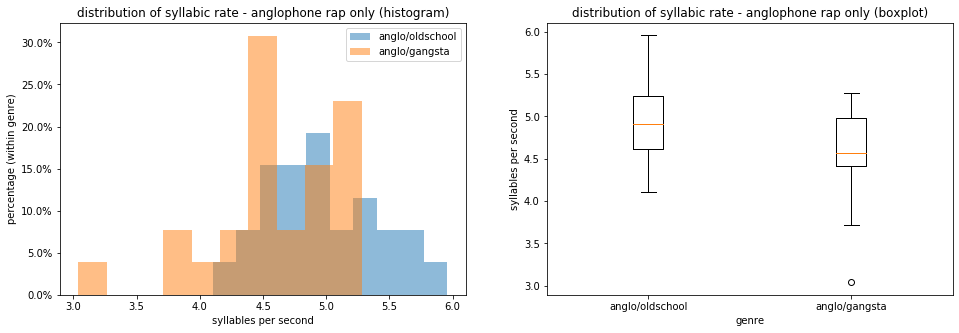

In [23]:
feature = 'syllabic_rate'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

for i in range(len(df_list_1)):
    data = df_list_1[i][1][feature]
     
    ax1.hist(data, weights=np.ones(len(data)) / len(data), alpha=0.5, label=labels_1[i])                
    ax2.boxplot(data, positions=[i]) 
    
ax1.yaxis.set_major_formatter(PercentFormatter(1))
ax1.legend()

ax1.set_title('distribution of syllabic rate - anglophone rap only (histogram)')
ax1.set_xlabel('syllables per second')
ax1.set_ylabel('percentage (within genre)')

ax2.set_title('distribution of syllabic rate - anglophone rap only (boxplot)')
ax2.set_xlabel('genre')
ax2.set_ylabel('syllables per second')

plt.sca(ax2)
plt.xticks(range(0,len(labels_1)), labels_1, rotation = 0)


plt.show()

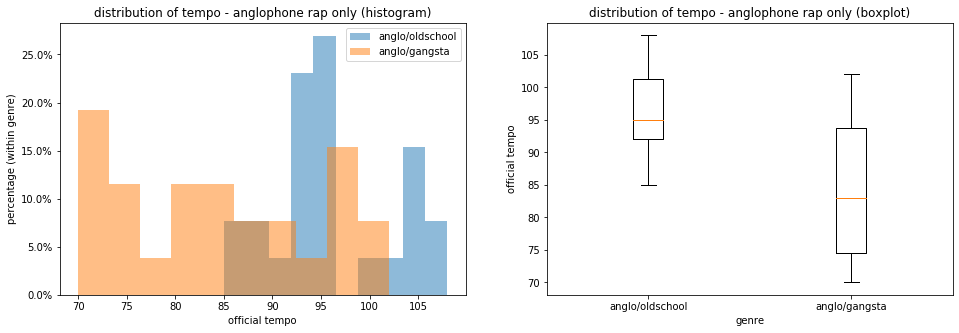

In [24]:
feature = 'tempo'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

for i in range(len(df_list_1)):
    data = df_list_1[i][1][feature]
     
    ax1.hist(data, weights=np.ones(len(data)) / len(data), alpha=0.5, label=labels_1[i])                
    ax2.boxplot(data, positions=[i]) 
    
ax1.yaxis.set_major_formatter(PercentFormatter(1))
ax1.legend()

plt.sca(ax2)
plt.xticks(range(0,len(labels_1)), labels_1, rotation = 0)

ax1.set_title('distribution of tempo - anglophone rap only (histogram)')
ax1.set_xlabel('official tempo')
ax1.set_ylabel('percentage (within genre)')

ax2.set_title('distribution of tempo - anglophone rap only (boxplot)')
ax2.set_xlabel('genre')
ax2.set_ylabel('official tempo')


plt.show()

In [29]:
# no song normalization - why? 
# why entropy??

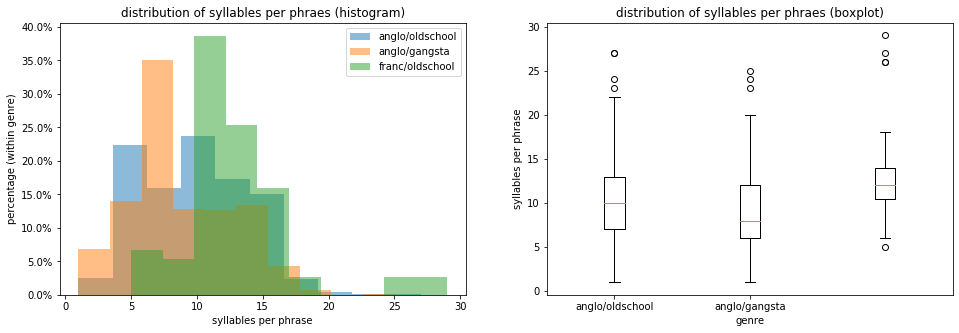

In [25]:
df_list_2 = list(df_dict.items())
labels_2 = list(df_dict.keys())

feature = 'phrase_syl'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

for i in range(len(df_list_2)):
    data = pd.concat(list(df_list_2[i][1][feature]))
     
    ax1.hist(data, weights=np.ones(len(data)) / len(data), alpha=0.5, label=labels_2[i])                
    ax2.boxplot(data, positions=[i]) 
    
ax1.yaxis.set_major_formatter(PercentFormatter(1))
ax1.legend()

plt.sca(ax2)
plt.xticks(range(0,len(labels_1)), labels_1, rotation = 0)

ax1.set_title('distribution of syllables per phraes (histogram)')
ax1.set_xlabel('syllables per phrase')
ax1.set_ylabel('percentage (within genre)')

ax2.set_title('distribution of syllables per phraes (boxplot)')
ax2.set_xlabel('genre')
ax2.set_ylabel('syllables per phrase')


plt.show()

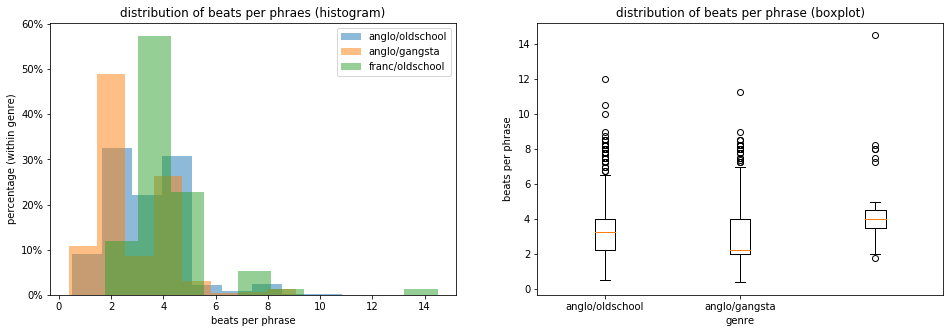

In [27]:
feature = 'phrase_beat'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

for i in range(len(df_list_2)):
    data = pd.concat(list(df_list_2[i][1][feature]))
     
    ax1.hist(data, weights=np.ones(len(data)) / len(data), alpha=0.5, label=labels_2[i])                
    ax2.boxplot(data, positions=[i]) 
    
ax1.yaxis.set_major_formatter(PercentFormatter(1))
ax1.legend()

plt.sca(ax2)
plt.xticks(range(0,len(labels_1)), labels_1, rotation = 0)

ax1.set_title('distribution of beats per phraes (histogram)')
ax1.set_xlabel('beats per phrase')
ax1.set_ylabel('percentage (within genre)')

ax2.set_title('distribution of beats per phrase (boxplot)')
ax2.set_xlabel('genre')
ax2.set_ylabel('beats per phrase')


plt.show()

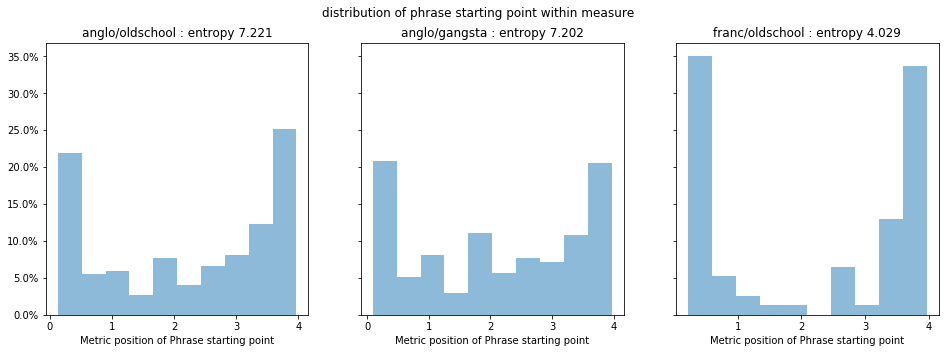

In [28]:
feature = 'breakpoints'

fig, axs = plt.subplots(1, 3, figsize=(16,5), sharey=True)

for i in range(len(df_list_2)):
    data = pd.concat(list(df_list_2[i][1][feature]))
     
    axs[i].hist(data, weights=np.ones(len(data)) / len(data), alpha=0.5, label=labels_2[i])                
    
    axs[i].yaxis.set_major_formatter(PercentFormatter(1))
    axs[i].set_xlabel('Metric position of Phrase starting point')
    axs[i].set_title('{0} : entropy {1}'.format(labels_2[i],np.round(entropy(data),3)))

plt.suptitle('distribution of phrase starting point within measure')


plt.show()

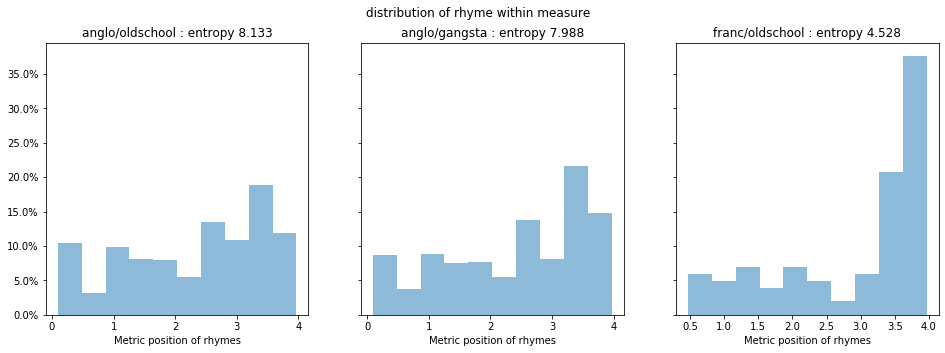

In [16]:
feature = 'rhyme'

fig, axs = plt.subplots(1, 3, figsize=(16,5), sharey=True)

for i in range(len(df_list_2)):
    data = pd.concat(list(df_list_2[i][1][feature]))
     
    axs[i].hist(data, weights=np.ones(len(data)) / len(data), alpha=0.5, label=labels_2[i])                
    
    axs[i].yaxis.set_major_formatter(PercentFormatter(1))
    axs[i].set_xlabel('Metric position of rhymes')
    axs[i].set_title('{0} : entropy {1}'.format(labels_2[i],np.round(entropy(data),3)))


plt.suptitle('distribution of rhyme within measure')


plt.show()

- Syllabic onsets per second: median and interquartile range are very similar between anglophone oldschools and gangstas. However, the spectrum of oldschool tends to be more talkative and fast, whereas gangsta spectrum is slower.

- Tempo: anglophone oldschool has faster tempo that its gangsta counterpart. The distribution is more constrained in the oldschool. On the other hand, tempo og anglophone gangsta is slower, with larger variance.

- Syllabic onsets per phrase: Anglophone raps shows no significant difference. Francophone oldschool appears to have more syllables in each phrase, but the numbe of data is so small.

- Beats per phrase: In all cases, peaks appear arount the multiples of 2 (half a measure). The distribution differs between three genres. In anglophone gangsta, phrases appears to be quite short, taking only two beats at most of the cases. In anglophone oldschool, beats per phrase is rather evenly distributed between half measure and whole measure. Francophone oldschool show a longest tail, but we do not know if we can generalize this result.

- Metric position of start or end point of phrase: In all genres, phrases tend to start at the first or last metrical position of measure. Considering the incompleteness of the francophone dataset, no significant or reliable difference is observed.

- Metric position of rhyme: same as above.

## 4. Discussions and Interpretaions


How do the results relate to your hypotheses? -> somewhat different, but no significant information inferred from the phrase points and rhymes. 

Did you find interesting or unexpected things? How do they influence your project? -> ...which was a bit unexpected. have to take a deeper view, but how?

What are problems that you encountered? How could you plan to deal with them? -> individual features may show some tendency, but it doesn't mean that ther are some evident 'norm flow' that fits it all


Do the analyses and results make sense? How can they be interpreted? -> mentioned above

What are the next steps in the project? -> analyzing the flow pattern? markov model or n-gram? most frequent sequence? 0th-ioi -> this will make analyzing the francophone data easier, we do not have to fix the parser.

Which aspects of your findings do you want to put in the center? -> beats, rhymes? phrase starting point -> do not take measure into account deeply

Which ones do you decide not to pursue further? -> rest-based analysis

- n-gram markov analysis 
- entropy 
- distribution of IOI within phrase
- distribution of IOI within measure
- entropy of metric position of rhyme
- entropy of metric position of start/end point of phrase

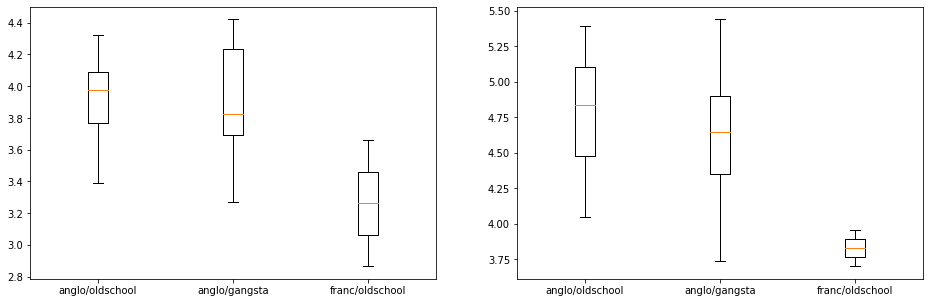

In [17]:
features = ['breakpoints','rhyme']

fig, axs = plt.subplots(1, 2, figsize=(16,5))
for k,feature in enumerate(features): 

#    fig = plt.figure()
#    ax = fig.add_subplot(111)
    for i in range(len(df_list_2)):
        en = np.array([])
        
        axs[k].boxplot(df_list_2[i][1][feature].apply(lambda x: entropy(x)), positions=[i])        
    plt.sca(axs[k])
    plt.xticks(range(0,len(labels_2)), labels_2, rotation = 0)
plt.show()